# Balancing Authority Generation by Fuel Type
This notebook pulls in generation data from the Energy Information Administration's (EIA's) API and creates simple plots of a Balancing Authority's (BA's) fuel mix. Note this includes only generation and not interchange, so we don't see patterns in imports/exports.

## 1. Paste in your EIA API Key
A key is required to access data through the EIA API, and instructions on registering for a key are available on the 
<a href="https://www.eia.gov/opendata/">EIA Open Data webpage</a>. This notebook won't run unless a valid key has been pasted into the spot below:

In [19]:
# paste in your key from EIA with quotation marks
key = ''

In [21]:
# import libraries needed
from datetime import datetime, timedelta
import math
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Make the EIA API Request
We set up our parameters for the GET request from the EIA API. In this example, we are looking for historical hourly load data for a selected BA.

In [23]:
# function to get EIA API data and put in dataframe
# this function gets a little complicated because EIA limits pull to 5000 observations,
# so we take the user's date range and break into sub-ranges, pulls data for each sub-range
# and then put all the data together
def eiaPull(BA,start_dt,end_dt):
    # the EIA API limits us to 5000 observations at a time, so we split up API call into 29 days each
    strt_dt_fmt = datetime.strptime(start_dt,'%Y-%m-%d').date() # make into date format
    end_dt_fmt = datetime.strptime(end_dt,'%Y-%m-%d').date()
    eia_days = max(0,(end_dt_fmt - strt_dt_fmt).days + 1) # number of days being pulled
    eia_pulls = min(40,math.ceil(eia_days/29)) # number of pulls have to make (no more than 29 days at a time) but limit to 40 pulls total
    strt_dt_fmt_i = strt_dt_fmt
    res_ls = [] # make empty list to store temp dfs
    eia_url='https://api.eia.gov/v2/electricity/rto/fuel-type-data/data/'
    # iterate through dates and pull data
    for i in np.arange(1,eia_pulls+1):
        #set up date range for pull
        end_dt_fmt_i = strt_dt_fmt_i + timedelta(days=min((end_dt_fmt - strt_dt_fmt_i).days,28))
        # define params
        eia_api_params = {'frequency':'hourly','data[0]':'value',
                  'facets[respondent][]':BA,
                  'start':datetime.strftime(strt_dt_fmt_i,"%Y-%m-%d")+"T00",
                  'end':datetime.strftime(end_dt_fmt_i,"%Y-%m-%d")+"T23",
                  'sort[0][column]':'period',
                  'sort[0][direction]':'asc','offset':'0'}
        eia_api_params['api_key'] = key
        # make request
        r_eia = requests.get(eia_url,params=eia_api_params,timeout=20)
        eia_results = json.loads(r_eia.text) # convert to dict
        print('Pulling',BA,'data for',strt_dt_fmt_i, 'to', end_dt_fmt_i, 'gave status code',r_eia.status_code)
        res_df = pd.DataFrame(eia_results["response"]["data"])
        res_ls.append(res_df) # put temp dfs into list
        strt_dt_fmt_i = end_dt_fmt_i + timedelta(days=1)
        # end for loop
    res_all_df = pd.concat(res_ls) # concatenate into one dataframe
    res_all_df = res_all_df[['period','respondent','fueltype','value']]
    res_all_df.columns = ['DateTime','BA','Fuel','MWh']
    res_all_df['DateTime'] = pd.to_datetime(res_all_df['DateTime'],utc=True) #make datetime
    res_all_df['MWh'] = pd.to_numeric(res_all_df['MWh']) #make numeric
    return res_all_df

In [7]:
# pull data for selected BA, start date, and end date (do no more than 3 years of data)
ba = 'NEVP'
eia_df = eiaPull(ba,'2022-10-01','2024-09-30')

Pulling NEVP data for 2022-10-01 to 2022-10-29 gave status code 200
Pulling NEVP data for 2022-10-30 to 2022-11-27 gave status code 200
Pulling NEVP data for 2022-11-28 to 2022-12-26 gave status code 200
Pulling NEVP data for 2022-12-27 to 2023-01-24 gave status code 200
Pulling NEVP data for 2023-01-25 to 2023-02-22 gave status code 200
Pulling NEVP data for 2023-02-23 to 2023-03-23 gave status code 200
Pulling NEVP data for 2023-03-24 to 2023-04-21 gave status code 200
Pulling NEVP data for 2023-04-22 to 2023-05-20 gave status code 200
Pulling NEVP data for 2023-05-21 to 2023-06-18 gave status code 200
Pulling NEVP data for 2023-06-19 to 2023-07-17 gave status code 200
Pulling NEVP data for 2023-07-18 to 2023-08-15 gave status code 200
Pulling NEVP data for 2023-08-16 to 2023-09-13 gave status code 200
Pulling NEVP data for 2023-09-14 to 2023-10-12 gave status code 200
Pulling NEVP data for 2023-10-13 to 2023-11-10 gave status code 200
Pulling NEVP data for 2023-11-11 to 2023-12-09 g

## 3. Create Variables

In [9]:
# create variables
gen_df = eia_df
#convert to local time
gen_df['DateTime'] = gen_df['DateTime'].dt.tz_convert('America/Los_Angeles')
gen_df['HE'] = gen_df['DateTime'].dt.hour+1
gen_df['Month'] = gen_df['DateTime'].dt.month
gen_df['Month_Abbr'] = gen_df['DateTime'].dt.strftime('%B')
gen_df['Season'] = np.where(gen_df['Month'].isin([12,1,2]), 'Winter',
                             np.where(gen_df['Month'].isin([3,4,5]), 'Spring',
                             np.where(gen_df['Month'].isin([6,7,8]), 'Summer',
                             'Fall')))
# create rolled up fuel type for charts
gen_df['Fuel_General'] = np.where(gen_df['Fuel'].isin(['OTH','NUC','OIL','WAT','WND']),'OTH',gen_df['Fuel'])

## 4. Make Plots of Fuel Mix Patterns

Text(0.5, 0.98, 'NEVP Fuel Mix by Season')

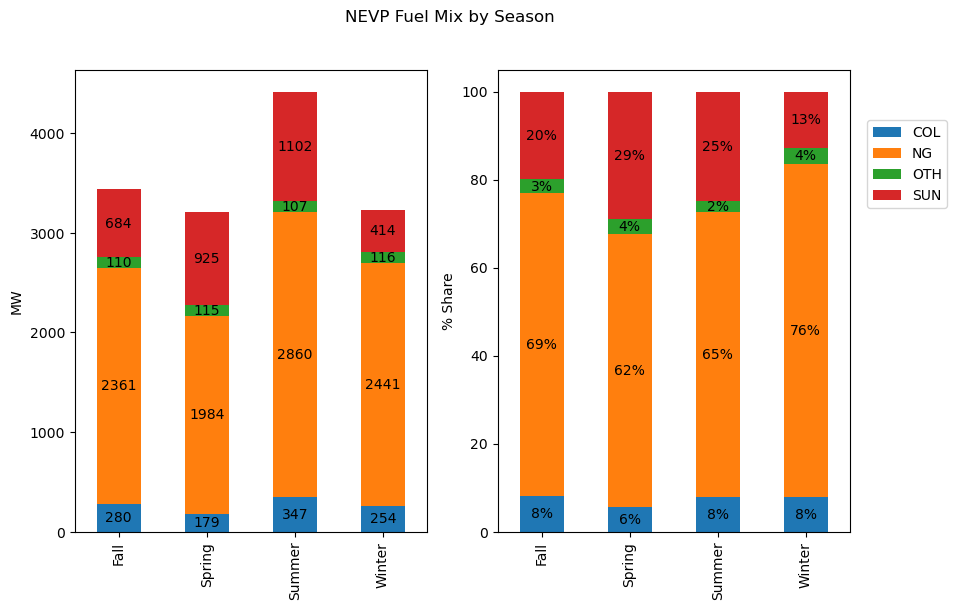

In [11]:
# fuel mix by season
season_avg = pd.DataFrame(gen_df.groupby(['Season','Fuel_General'])['MWh'].mean()) # each fuel's avg MW by season
season_share = season_avg.groupby('Season')['MWh'].transform(lambda x: (x/x.sum())*100) # each fuel's % share by season
fig_s, (ax1,ax2) = plt.subplots(1,2, figsize=(10,6)) #1x2 subplots

# fuel MW by season
season_avg.unstack().plot(kind='bar', stacked=True,
                          xlabel='', ylabel='MW',
                         ax=ax1)
# add data labels for first subplot
for p in ax1.containers:
    ax1.bar_label(p, label_type='center',fmt='%.f')
ax1.get_legend().remove() # no legend

# fuel % share by season
season_share.unstack().plot(kind='bar', stacked=True,
                          xlabel='', ylabel='% Share',
                                 ax=ax2)
# add data labels for second subplot
for p in ax2.containers:
    ax2.bar_label(p, label_type='center',fmt='%1.0f%%')
ax2.legend(loc=(1.05,0.7)) # add legend
fig_s.suptitle(ba + ' Fuel Mix by Season')

Text(0.5, 0.98, 'NEVP Fuel Mix by Month')

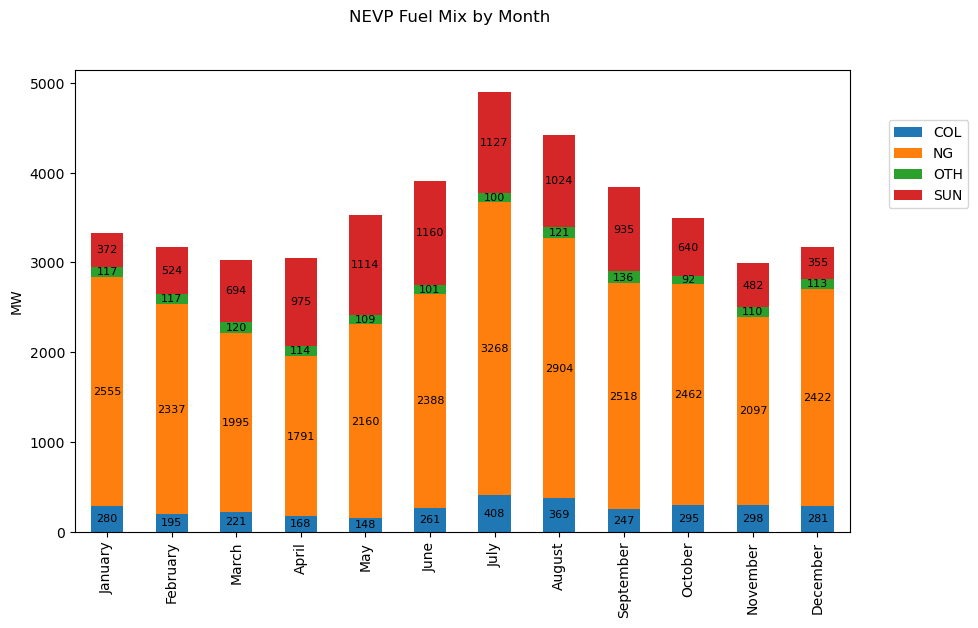

In [13]:
# average fuel mix by month of year
mth_avg = gen_df.groupby(['Month','Month_Abbr','Fuel_General'])['MWh'].mean().unstack().sort_values(by=['Month']) 
fig_m, ax_m = plt.subplots(figsize=(10,6))
mth_avg.droplevel('Month').plot(kind='bar',stacked=True,xlabel='',ylabel='MW',ax=ax_m)
# add data labels
for p in ax_m.containers:
    ax_m.bar_label(p, label_type='center',fmt='%.f',fontsize=8)
ax_m.legend(loc=(1.05,0.7)) # add legend
fig_m.suptitle(ba + ' Fuel Mix by Month')

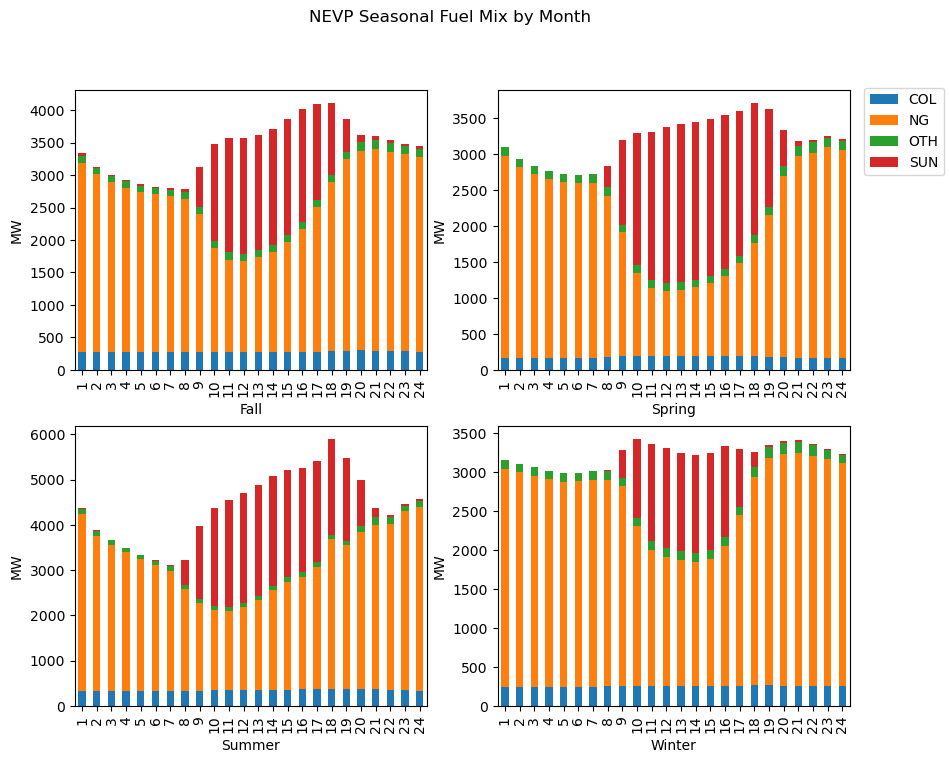

In [17]:
seas_he_avg = gen_df.groupby(['Season','HE','Fuel_General'])['MWh'].mean().unstack()
fig_sh, axes = plt.subplots(2,2,figsize=(10,8))
# loop through and show subplot for each season
# i is season, j is subset of data for that season, ax is axis it will be one
for (i,j), ax in zip (seas_he_avg.groupby(['Season']), axes.flat): #flaten axes to 1d array for iterating
    j.plot.bar(stacked=True,ax=ax)
    ax.get_legend().remove()
    ax.set_xticklabels(np.arange(1,25))
    ax.set_xlabel(i[0])
    ax.set_ylabel('MW')
fig_sh.suptitle(ba + ' Seasonal Fuel Mix by Month')
# make legend using info from last axis plotted
fig_sh.legend(ax.get_legend_handles_labels()[0],ax.get_legend_handles_labels()[1],loc=(0.91,0.77))